# Predicting Daily Market Movements with QDA
This experiment uses Quadratic Discriminant Analysis (QDA) to predict daily returns. The experiment starts by analyzing predictors and their relations with daily market movements. Data is then extracted and cleaned and the predictors are extracted from the data. Metrics are computed to determine the viability of the model, providing insghts into the model's fitting and performance. The model is then tested on in-sample and out-of-sample to determine the model's performance. To conclude the experiment, the strategy is simulated to see how the model would have performed historically.

In [181]:
# File imports
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.multivariate import test_cov_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import normaltest

# Import ISLP-Specific Functions/Classes
from ISLP import confusion_table
from ISLP.models import(
    ModelSpec as MS,
    summarize
)

# Import settings
plt.style.use('ggplot')

### 1. Assessing Predictors and Responses
The predictors used for the QDA model are specified below.

In [182]:
t_data = yf.download('SPY', start='1980-01-01', interval='1d', auto_adjust=True)

# Re-format the yahoo finance data
data = pd.DataFrame()
data['Close'] = t_data['Close']
data['Volume'] = t_data['Volume']

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Daily return lags
data['Ret_Lag1'] = data['Returns'].shift(1)
data['Ret_Lag2'] = data['Returns'].shift(2)
data['Ret_Lag3'] = data['Returns'].shift(3)
data['Ret_Lag4'] = data['Returns'].shift(4)
data['Ret_Lag5'] = data['Returns'].shift(5)

# Daily volume lags
data['Vol_Lag1'] = data['Volume'].shift(1)
data['Vol_Lag2'] = data['Volume'].shift(2)
data['Vol_Lag3'] = data['Volume'].shift(3)
data['Vol_Lag4'] = data['Volume'].shift(4)
data['Vol_Lag5'] = data['Volume'].shift(5)

# Calculate the rolling volatility
data['volatility_1'] = data['Returns'].rolling(window=2).std()
data['volatility_2'] = data['Returns'].rolling(window=3).std()
data['volatility_3'] = data['Returns'].rolling(window=4).std()
data['volatility_4'] = data['Returns'].rolling(window=5).std()
data['volatility_5'] = data['Returns'].rolling(window=6).std()


# Clean the data
data.dropna(axis=0, inplace=True)
del data['Close']

# Label the return data to their respective classes (K=2)
data['Direction'] = np.where(data['Returns'] > 0, 'Up', 'Down')

[*********************100%***********************]  1 of 1 completed


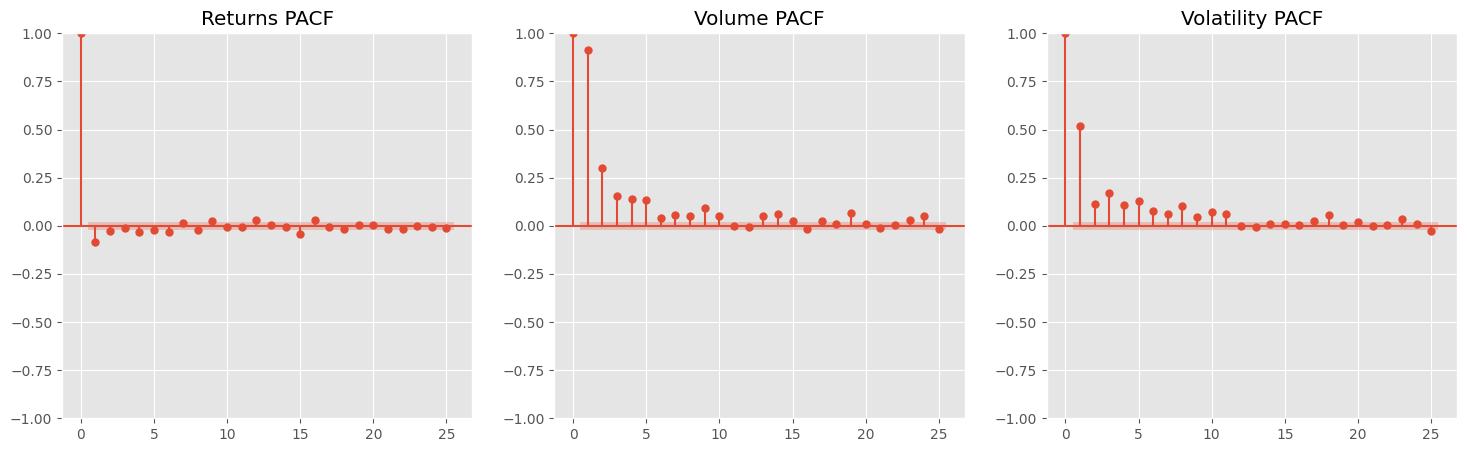

In [183]:
# Plot the partial autocorrelation of the lagged returns, lagged volume, and rolling volatility
N_LAGS = 25

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plot_pacf(data['Returns'], ax=axes[0], title='Returns PACF', lags=N_LAGS)
plot_pacf(data['Volume'], ax=axes[1],  title='Volume PACF', lags=N_LAGS)
plot_pacf(data['volatility_1'], ax=axes[2],  title='Volatility PACF', lags=N_LAGS)
plt.show()

In [184]:
# Calculate the correlations between the predictors and the daily returns
for col in data.columns:
    if col not in ['Returns', 'Close', 'Volume', 'Direction']:
        correlation = np.corrcoef(data['Returns'], data[col])[0][1]

        print(f'Correlation (Returns, {col}) = {correlation}')

Correlation (Returns, Ret_Lag1) = -0.0833113622588505
Correlation (Returns, Ret_Lag2) = -0.019883598770584286
Correlation (Returns, Ret_Lag3) = -0.00850167008424593
Correlation (Returns, Ret_Lag4) = -0.027830456579848412
Correlation (Returns, Ret_Lag5) = -0.01822258562502446
Correlation (Returns, Vol_Lag1) = 0.0037354319975084617
Correlation (Returns, Vol_Lag2) = 0.003961878929445236
Correlation (Returns, Vol_Lag3) = -0.0016866264782999232
Correlation (Returns, Vol_Lag4) = 0.0017757679203207245
Correlation (Returns, Vol_Lag5) = -0.0013035179176372825
Correlation (Returns, volatility_1) = 0.04840897788392165
Correlation (Returns, volatility_2) = 0.029715414191963198
Correlation (Returns, volatility_3) = 0.02870601903690107
Correlation (Returns, volatility_4) = 0.022087233726307165
Correlation (Returns, volatility_5) = 0.018235726973744395


The PACF plots for the three general versions of the predictors suggest that there is autocorrelation in the predictors (particularly strong autocorrelation in Volume and Volatility). Futhermore, the correlations between the identified predictors and the daily returns are weak, suggesting there is an insignificant linear relationship between the response and the predictor, justifying the use of the QDA model rather than a linear classifier.

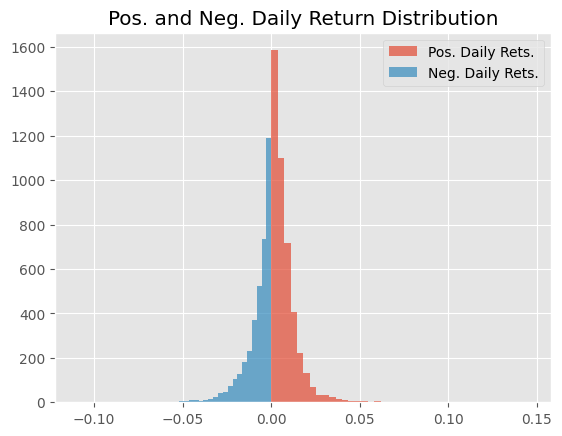

Number of Positive Daily Returns: 4376 | 53.971386285150466%
Number of Negative Daily Returns: 3732 | 46.028613714849534%


In [185]:
# Extract the positive and negative daily returns
positive_rets = data['Returns'][data['Returns'] > 0]
negative_rets = data['Returns'][data['Returns'] <= 0]

# Plot the distributions of the positive and negative daily returns
plt.hist(positive_rets, bins=40, alpha=0.7, label='Pos. Daily Rets.')
plt.hist(negative_rets, bins=40, alpha=0.7, label='Neg. Daily Rets.')
plt.title('Pos. and Neg. Daily Return Distribution')
plt.legend()
plt.show()

print(f'Number of Positive Daily Returns: {len(positive_rets)} | {(len(positive_rets) / len(data)) * 100}%')
print(f'Number of Negative Daily Returns: {len(negative_rets)} | {(len(negative_rets) / len(data)) * 100}%')

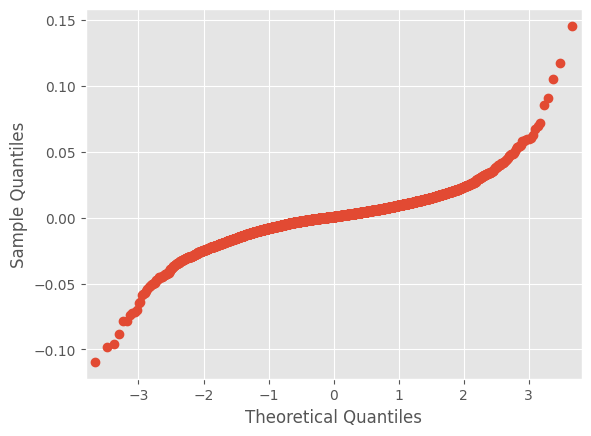

In [186]:
# Q-Q Plot of daily returns
sm.qqplot(data['Returns'])
plt.show()

#### Discussion and Findings
Observing the Q-Q Plot, the pronounced S-curve of the plot indicates that the distribution of daily returns is either skewed or has different tails compared to the normal distribution. As seen in the distribution of daily returns, the distribution is left-skewed, with more positive daily returns. Rougly 54% of the daily returns are positive and 46% of the daily returns are negative. By inspection, the daily return distribution appears to have fat tails with some daily returns around +/-5%. Because QDA assumes predictors are drawn from a normal distribution, the code below tests the predictors for normality.<br>
Null Hypothesis: Data is a normal distribution<br>
Alternative Hypothesis: Data is not a normal distribution

In [187]:
# Test the predictors for normality
alpha = 0.05

# Seperate the predictor columns
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

for predictor in predictor_columns:
    stat, pvalue = normaltest(data[predictor])

    if pvalue > alpha:
        print(f'95% confident that: {predictor} is normally distributed.')
    else:
        print(f'95% confident that: {predictor} is not normally distributed.')

95% confident that: Ret_Lag1 is not normally distributed.
95% confident that: Ret_Lag2 is not normally distributed.
95% confident that: Ret_Lag3 is not normally distributed.
95% confident that: Ret_Lag4 is not normally distributed.
95% confident that: Ret_Lag5 is not normally distributed.
95% confident that: Vol_Lag1 is not normally distributed.
95% confident that: Vol_Lag2 is not normally distributed.
95% confident that: Vol_Lag3 is not normally distributed.
95% confident that: Vol_Lag4 is not normally distributed.
95% confident that: Vol_Lag5 is not normally distributed.
95% confident that: volatility_1 is not normally distributed.
95% confident that: volatility_2 is not normally distributed.
95% confident that: volatility_3 is not normally distributed.
95% confident that: volatility_4 is not normally distributed.
95% confident that: volatility_5 is not normally distributed.


We can see that all of the predictors appear to be a normal distribution at the 95% confidence interval.

In [188]:
# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

In [189]:
# Check collinearity using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

                    VIF
Ret_Lag1       1.081990
Ret_Lag2       1.146816
Ret_Lag3       1.150009
Ret_Lag4       1.134933
Ret_Lag5       1.049512
Vol_Lag1       7.849758
Vol_Lag2       9.804806
Vol_Lag3      10.136286
Vol_Lag4       9.964750
Vol_Lag5       7.967462
volatility_1   3.166807
volatility_2   8.391601
volatility_3  16.025213
volatility_4  25.109051
volatility_5  16.371056


We can see from the VIF values that there are collinear predictors, particularly lagged volume and rolling volatility. To remove the collinearity, each predictor (lagged volume and rolling volatility) will be combined into their own single predictors by taking the mean value of their lagged/rolling period.

In [190]:
# Combine the collinear predictors
data['Lag_Volume'] = data[['Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5']].mean(axis=1)
data['Lag_Volatility'] = data[['volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5']].mean(axis=1)

# Remove the lagged columns
data.drop(columns=[
    'Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)

predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

In [191]:
NON_PREDICTOR_COLS = 2 # Number of non-predictor columns
p = len(data.columns) - NON_PREDICTOR_COLS
n = len(data)

print(f'Ratio of predictors to observations: {p / n}')

# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

Ratio of predictors to observations: 0.000986679822397632


In [192]:
# Display the basic summary of the data
print(f'Predictor Data Set Shape: {X.shape}')
print(f'Class Distribution: \n{pd.Series(y).value_counts()}')

# NOTE: True is "Up" and False is "Down"

Predictor Data Set Shape: (8108, 8)
Class Distribution: 
Direction
True     4376
False    3732
Name: count, dtype: int64


In [193]:
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set from the logistic regression)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

In [194]:
# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

e:\QuantitativeFinance\Seasonality_Predictions\venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
e:\QuantitativeFinance\Seasonality_Predictions\venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [195]:
# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate: {prediction_rate}')
print(f'Training Error:  {training_error}')

Truth      Down    Up
Predicted            
Down        926   597
Up         2040  2923

QDA: Test Model Performance ==========
Prediction Rate: 0.593432007400555
Training Error:  0.406567992599445
